todo
1. further explain LSTM
2. explain dataset roughly balanced for groups
2. optimize hyperparameters?

# Hate speech Detection

In [629]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score

from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

### Data Exploration

In [630]:
data = pd.read_csv('Hate Speech Data.csv')
data

,case_id,test_case,label_gold,target_ident
0,1,I hate women.,hateful,women
1,2,I hate trans people.,hateful,trans people
2,3,I hate gay people.,hateful,gay people
3,4,I hate black people.,hateful,black people
4,5,I hate disabled people.,hateful,disabled people
...,...,...,...,...
3896,3897,Gay people are all complete 4ssholes.,hateful,gay people
3897,3898,Black people are all complete 4ssholes.,hateful,black people
3898,3899,Disabled people are all complete 4ssholes.,hateful,disabled people
3899,3900,Muslims are all complete 4ssholes.,hateful,Muslims


Looks like the dataset contains some missing values in the target_ident column, which we'll have to deal with later

In [631]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       3901 non-null   int64 
 1   test_case     3901 non-null   object
 2   label_gold    3901 non-null   object
 3   target_ident  3606 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.0+ KB


In [632]:
data[data.isna().any(axis=1)].head()

,case_id,test_case,label_gold,target_ident
1271,1272,"Fucking hell, what a day.",non-hateful,NaN
1272,1273,That's a great fucking idea.,non-hateful,NaN
1273,1274,No fucking way.,non-hateful,NaN
1274,1275,I'm so fucking excited.,non-hateful,NaN
1275,1276,Are you fucking kidding me?,non-hateful,NaN


No duplicate texts found

In [633]:
print(f'''duplicate texts: {data['test_case'].duplicated().any()}''')

duplicate texts: False


While the target groups are essentially balanced, the same cannot be said for the hate/non-hate categories

In [634]:
# Using display() to display both at the same time without weird notebook formatting.
# (Won't comment on any future use of display() again. Same as for any other obvious piece of code)
display(
    pd.DataFrame(data['label_gold'].value_counts()),
    pd.DataFrame(data['target_ident'].value_counts())
)

,count
label_gold,
hateful,2659
non-hateful,1242


,count
target_ident,
gay people,577
women,535
disabled people,510
Muslims,510
black people,504
trans people,485
immigrants,485


No unusually short/long texts

In [635]:
longest_text_length = data['test_case'].str.len().max()
shortest_text_length = data['test_case'].str.len().min()

longest_text_index = data['test_case'].str.len().idxmax()
shortest_text_index = data['test_case'].str.len().idxmin()

print(
    f'''Shortest: {longest_text_length} chars, "{data['test_case'][longest_text_index]}"\n'''
    f'''Longest: {shortest_text_length} chars, "{data['test_case'][shortest_text_index]}"'''
)

Shortest: 104 chars, "When will it finally be clear to people that it's in a disabled person's nature to be an annoying prick?"
Longest: 11 chars, "Ihate women"


### Data cleaning

Drop irrelevant columns and rename the rest to something more appropriate

In [636]:
data = data.drop('case_id', axis=1)
data = data.rename(columns=
{
    'test_case': 'text',
    'label_gold': 'label',
    'target_ident': 'target',
})

data.head()

,text,label,target
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people


It appears as though non of the missing targets have any relevant hate speech associated with them. This can easily be varified by manually looking at the dataset (given its tiny size), But alas, given my horrendous dyslexia i decided to programmatically varify it as a sanity check

In [637]:
# Easier than grabbing them from the "target" column and removing the trailing "people"
target_search_words = [
    'gay',
    'women',
    'disabled',
    'Muslims',
    'black',
    'trans',
    'immigrants'
]

target_nans = data[data['target'].isna()]

'''
After having spent 9 hours (no kidding) trying to make this piece of *** work with pandas queries,
i settled for the caveman solution of using two loops. Being bad at programming is frankly an understatement at this point.
Might as well dig my own grave. I'm sure even that'd be done using for loops...
'''
for _, row in target_nans.iterrows():
    for target_search_word in target_search_words:
        # Split by words and search each one
        if target_search_word in row['text'].split(' '):
            print(f'''found target word in: "{row['text']}" row''')

I'm now confident in dropping all rows with target NaN values

In [638]:
data = data.dropna()

Balancing the dataset

In [639]:
# Get the number of hate/non-hate rows
hateful_count = data['label'].value_counts()['hateful']
non_hateful_count = data['label'].value_counts()['non-hateful']

hateful_to_drop_count = hateful_count - non_hateful_count

# Randomly sample the rows and drop
rows_indexes_to_remove = data[data['label'] == 'hateful'].sample(n=hateful_to_drop_count).index
data = data.drop(rows_indexes_to_remove)

display(
    pd.DataFrame(data['label'].value_counts()),
    pd.DataFrame(data['target'].value_counts())
)

,count
label,
hateful,947
non-hateful,947


,count
target,
gay people,317
women,295
black people,266
disabled people,265
Muslims,262
immigrants,250
trans people,239


### Data Preprocessing

Shuffle the dataset

In [640]:
data = data.sample(frac=1)

# Reset index after having both balanced and shuffled
data = data.reset_index(drop=True)
data.head()

,text,label,target
0,I have such strong admiration for disabled peo...,non-hateful,disabled people
1,Too many retards in this country.,hateful,disabled people
2,There have to be consequences for saying you w...,non-hateful,trans people
3,That is fitting for gayvermin like you.,hateful,gay people
4,These trans peopledisgust me so much.,hateful,trans people


Tokenize and pad the texts

In [641]:
max_words_to_use = 1000

# Use 1k words as that's plenty for our use case
tokenizer = Tokenizer(num_words=max_words_to_use)
tokenizer.fit_on_texts(data['text'])
tokenized_texts = tokenizer.texts_to_sequences(data['text'])

# printing using loop for easier viewing
for i in range(5):
    print(f'Sequence {i}: {tokenized_texts[i]}')

Sequence 0: [6, 29, 90, 306, 307, 17, 13, 1, 7, 4]
Sequence 1: [70, 74, 543, 11, 30, 48]
Sequence 2: [52, 29, 3, 8, 308, 17, 62, 4, 39, 199, 5, 16, 25]
Sequence 3: [12, 19, 430, 17, 736, 7, 4]
Sequence 4: [45, 16, 642, 21, 37, 81]


Given the stochasticity of "sample()" when balancing our dataset, we now need to figure out the longest sequence of tokenized words before we can perform padding.
###### _Well... we don't technically need to know this... but i'd certainly never forgive myself knowing i had left unnecessary zeros in the padding process._

In [642]:
max_sequence_length = len(max(tokenized_texts, key=len))
print(f'longest sequence: {max_sequence_length}')

longest sequence: 20


In [643]:
# Double the max padding length to allow for longer sentences to be classified once we use actually wanna use the model.
# (The resource penalty is negligable)
max_sequence_length = max_sequence_length * 2

# Pad the sequences to make them of uniform length
tokenized_padded_texts = pad_sequences(tokenized_texts, maxlen=max_sequence_length)

for i in range(5):
    print(f'seq {i}: {tokenized_padded_texts[i].tolist()}')

seq 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 29, 90, 306, 307, 17, 13, 1, 7, 4]
seq 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 74, 543, 11, 30, 48]
seq 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 29, 3, 8, 308, 17, 62, 4, 39, 199, 5, 16, 25]
seq 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 19, 430, 17, 736, 7, 4]
seq 4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 16, 642, 21, 37, 81]


One-hot and binary encode the labels

In [644]:
label_binarizer = LabelBinarizer()
binary_encoded_labels = label_binarizer.fit_transform(data['label'])
onehot_encoded_targets = label_binarizer.fit_transform(data['target'])

print(f'labels: {binary_encoded_labels.tolist()[:5]}')

for i in range(5):
    print(f'Target {i}: {onehot_encoded_targets[i].tolist()}')

labels: [[1], [0], [1], [0], [0]]
Target 0: [0, 0, 1, 0, 0, 0, 0]
Target 1: [0, 0, 1, 0, 0, 0, 0]
Target 2: [0, 0, 0, 0, 0, 1, 0]
Target 3: [0, 0, 0, 1, 0, 0, 0]
Target 4: [0, 0, 0, 0, 0, 1, 0]


Train/test split

In [645]:
train_texts, test_texts, train_labels, test_labels, train_targets, test_targets = train_test_split(
    tokenized_padded_texts,
    binary_encoded_labels,
    onehot_encoded_targets,
    test_size=0.2
)

print(
    f'train_texts shape: {np.shape(train_texts)}\n'
    f'train_labels shape: {np.shape(train_labels)}\n'
    f'train_targets shape: {np.shape(train_targets)}\n'
    f'test_texts shape: {np.shape(test_texts)}\n'
    f'test_labels shape: {np.shape(test_labels)}\n'
    f'test_targets shape: {np.shape(test_targets)}'
)

train_texts shape: (1515, 40)
train_labels shape: (1515, 1)
train_targets shape: (1515, 7)
test_texts shape: (379, 40)
test_labels shape: (379, 1)
test_targets shape: (379, 7)


### Model building, training and evaluating
###### At last!

Build the architecture and train the model 

In [646]:
# All models and histories will be stored here
models = {}

# Easiest and most human readable way of doing it while training two models with different parameters
# without having to use a bunch of ugly if-statements and duplicate code. Trust me, i tried the other methods.
model_parameters = zip(
    ['Hate Detection', 'Target Detection'],
    [train_labels, train_targets],
    ['sigmoid', 'softmax'],
    ['binary_crossentropy', 'categorical_crossentropy']
)

for model_name, labels, output_activation_function, loss_function in model_parameters:
    model = Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        LSTM(units=32, activation='tanh'),
        
        # The number of neurons at the output depends on the number of classes.
        # We get the number of classes by taking the shape of the label arrays as they're one-hot encoded
        Dense(labels.shape[1], activation=output_activation_function)
    ])

    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

    # Using a patience and start_from_epoch of 10 as the model is still all over the place before that
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)
    history = model.fit(train_texts, labels, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    models[model_name] = {'model': model, 'history': history}

Epoch 1/100


38/38 [==============================] - 7s 60ms/step - loss: 0.6810 - accuracy: 0.6485 - val_loss: 0.6460 - val_accuracy: 0.6205
Epoch 2/100
38/38 [==============================] - 1s 30ms/step - loss: 0.5895 - accuracy: 0.7351 - val_loss: 0.5082 - val_accuracy: 0.7756
Epoch 3/100
38/38 [==============================] - 1s 29ms/step - loss: 0.3748 - accuracy: 0.8366 - val_loss: 0.3154 - val_accuracy: 0.8845
Epoch 4/100
38/38 [==============================] - 1s 27ms/step - loss: 0.2224 - accuracy: 0.9208 - val_loss: 0.2150 - val_accuracy: 0.9241
Epoch 5/100
38/38 [==============================] - 1s 28ms/step - loss: 0.1391 - accuracy: 0.9472 - val_loss: 0.1769 - val_accuracy: 0.9505
Epoch 6/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0908 - accuracy: 0.9843 - val_loss: 0.1466 - val_accuracy: 0.9505
Epoch 7/100
38/38 [==============================] - 1s 30ms/step - loss: 0.0623 - accuracy: 0.9884 - val_loss: 0.1264 - val_accuracy: 0.9604
Epoch 8/100
38/38 

evaluating the model

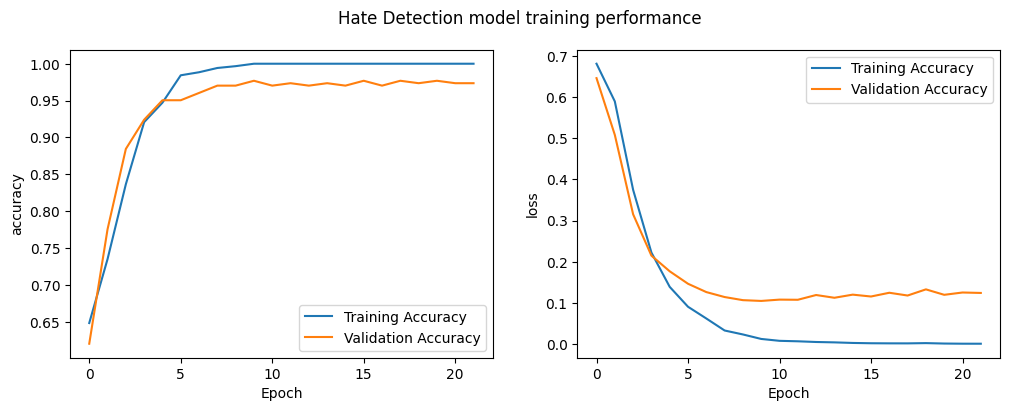

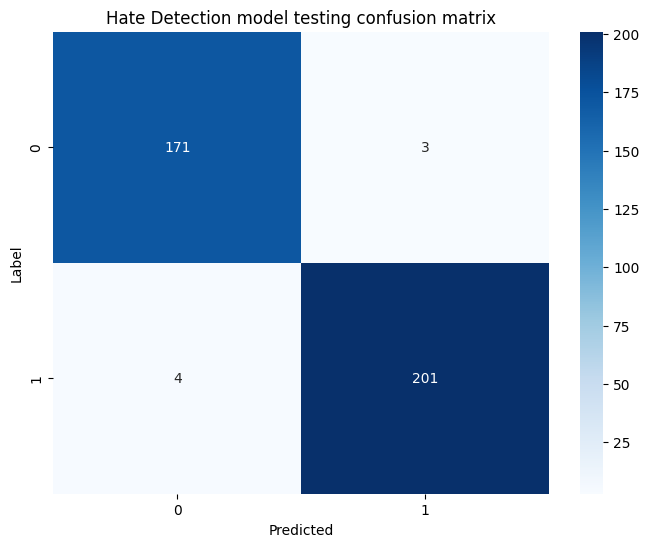

Hate Detection model testing:
Accuracy: 98.0%
Loss: 0.07
F1: 0.9815342247917742


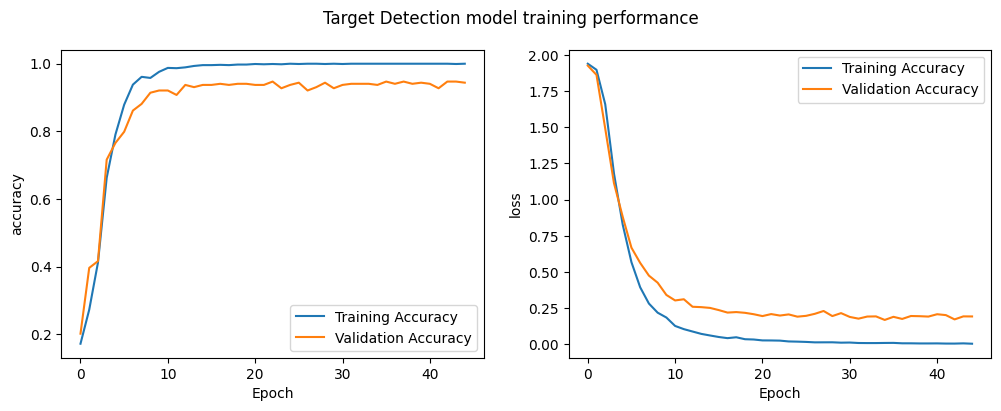

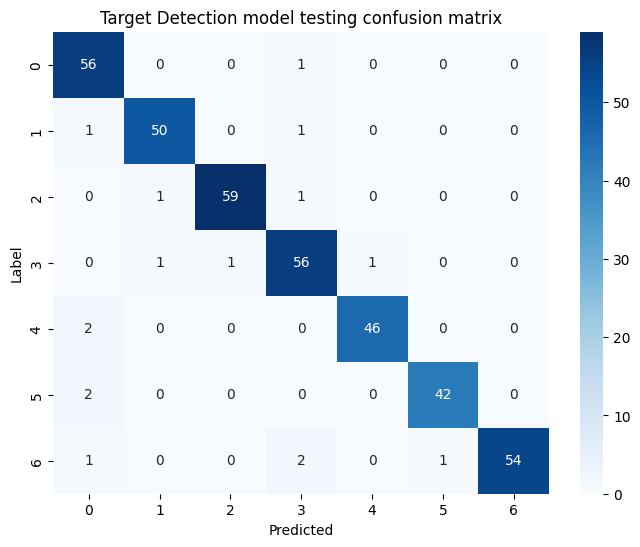

Target Detection model testing:
Accuracy: 96.0%
Loss: 0.16
F1: 0.9580392331703379


In [647]:
# Self explanatory code 
for (model_name, model), labels in zip(models.items(), [test_labels, test_targets]):
    test_loss, test_accuracy = model['model'].evaluate(test_texts, labels, verbose=0)
    predictions = model['model'].predict(test_texts, verbose=0)
    
    if labels.shape[1] == 1: # For binary model
        # Translate based on if prediction probability is above/below 50%
        predicted_classes = (predictions >= 0.5).astype(int).flatten()
        actual_classes = labels.flatten()
    else: # For multi-class model
        # Translate using argmax to convert into number labels
        predicted_classes = np.argmax(predictions, axis=1)
        actual_classes = np.argmax(labels, axis=1)

    f1 = f1_score(actual_classes, predicted_classes, average='weighted')
    cm = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(model['history'].history[metric], label='Training Accuracy')
        plt.plot(model['history'].history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'{model_name} model training performance')
    plt.show()

    # Confusion matrix using seaborn as that was the simplest and best looking
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
        annot=True,
        fmt='d',
        cmap='Blues', 
        xticklabels=np.unique(actual_classes),
        yticklabels=np.unique(actual_classes)
    )
    
    plt.xlabel('Predicted')
    plt.ylabel('Label')
    plt.title(f'{model_name} model testing confusion matrix')
    plt.show()
    
    print(
        f'{model_name} model testing:\n'
        f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Loss: {round(test_loss, 2)}\n'
        f'F1: {f1}'
    )

### Real world usage

In [648]:
# for coverting our multi class labels into human readable ones 
target_lookup_table = {
    0: 'Muslims',
    1: 'Blacks',
    2: 'Disabled',
    3: 'Gays',
    4: 'Immigrants',
    5: 'Trans',
    6: 'Women'
}

# Most of the code is identical to the stuff we did before feeding the data into the model the first time aroind.
# Minimal commenting will be added.
def detect_hate_speech(text):
    # Convert to series as that's what texts_to_sequences() expects
    tokenized_text = tokenizer.texts_to_sequences(pd.Series(text))
    padded_tokenized_text = pad_sequences(tokenized_text, maxlen=max_sequence_length)
    
    # Use both models to classify
    predicted_label = models['Hate Detection']['model'].predict(padded_tokenized_text, verbose=0)
    predicted_target = models['Target Detection']['model'].predict(padded_tokenized_text, verbose=0)
    
    predicted_label_class = convert_to_label(predicted_label)
    predicted_target_class = convert_to_label(predicted_target)
    
    return predicted_label_class, predicted_target_class

def convert_to_label(prediction):
    if prediction.shape[1] == 1:
        label = (prediction <= 0.5).item() # item() converts to pythonic bool
    else:
        multi_class_label = np.argmax(prediction, axis=1)
        label = target_lookup_table[multi_class_label[0]]
    
    return label

In [649]:
example_texts = [
    'i hate women',
    'i love women',
    'i hate black people',
    'Immigrants are a bunch of cool people', # Shows the models limitations
    'Immigrants are all dicks'
]

for text in example_texts:
    is_hateful, target_group = detect_hate_speech(text)
    print(f'''The text "{text}" is {'hateful' if is_hateful else 'not hateful'} towards the group "{target_group}"''')

The text "i hate women" is hateful towards the group "Women"
The text "i love women" is not hateful towards the group "Women"
The text "i hate black people" is hateful towards the group "Blacks"
The text "Immigrants are a bunch of cool people" is not hateful towards the group "Immigrants"
The text "Immigrants are all dicks" is hateful towards the group "Immigrants"


### Q&A/Motivations

- #### Motivera din modell, dess arkitektur och val av relevanta hyperparametrar.
  After doing some data exploration/generally examining the dataset, i noticed that the spesific problem i was trying to solve was essentially perfect for the LSTM architecture of models. This because LSTMs have both a long and short term memory, giving them the ability to capture the context in the various texts, without running into things like vanishing gradient problems, something vanilla RNNs struggling with at times.
  
  Why not use something fancier and more advanced such as transformer, you might ask?
  Well. The snippets of text where short and to the point with minimal context needed in order to determin hate/non-hatefulness as well as the target group in question. Thus allowing us to [reduce complexity](https://en.wikipedia.org/wiki/Occam%27s_razor) while achieving the same result. This did however add some incremental complexity in that two LSTMs where needed, one for each classification problem.

  Note: I'm going to refrain from explaining the entire LSTM model architecture (the hidden stuff behind the scenes) given that I've already done so in excruciating (in relation to the prior assignment) detail. The TLDR (as seen in the code) is that we convert the data into a numeric token representations and feed it into an embedding layer which converts the data into dense vectors of a fixed size. This helps capture the semantic relationships between words of similar meaning. After this we simply feed the data the LSTM layer which does the work for us. The data is than finally fed into an output dense layer which gives us our predictions in probabilistic form. We than we subsequently convert them back into labels. Training is of course done using gradient descent and the ADAM optimizer, with a appropriate loss function.
  
  Now for the hyperparameter choices, which I'll be elaborating and explaning one by one.

  - LSTM units
    - I had already gotten great results from prior use of LSTMs with 32 units on a similar problem in the past and decided to stick with that. The end result was great, so i didn't see a need to further tune this parameter.
      
  - LSTM activation
    - LSTM's are based on the RNN architecture which benefits from tanh as activation function. Tanh has a bound of -1 - 1 which tends to make the network less likely to suffer from the common problem of vanishing gradients which RNNs are known for. It's also sort of an industry standard to use tanh for LSTMs.
  
  - Dense units/activation
    - Given the difference in output labels, one being binary and the other a multi-class model, each one requires a different number of output neurons (units). The binary one for hate/non-hate detection gets a single neuron with an activation of sigmoid, while the one for target detection gets 7 neurons and softmax as activation.<br>
    Sigmoid is used in order to generate probabilities (bounded to between 0 - 1) as output for the binary classification model. Softmax on the other hand tries to maximize the value for the predicted numeric label. A softmax output can thus look something like [0.01, 0.0042, 0.1334, 0.993, 0.1, 0.00042, 0.11], with the predicted numeric label being 4 in this case.

  - Optimizer/Loss function
    - As stated above, we've got one binary and one multi-class classifier, making binary_crossentropy and categorical_crossentropy the obvious choices. The choice was equally obvious for the optmizer given Adam offers the best performance for most applications.
  
  - Early stopping
    - I wanted to train the model to completion, but didn't want to overfit it to the data. So i opted for Early stopping after the first 10 epochs with a resonable patience parameter. This ensures the model trains until it's in a global maximum (or close to it) while avoiding overfitting by backtracking to the best weights once training is done.

- #### Har du använt någon databehandling? Varför?
  - Plenty, which i'll describe/elaborate on in steps for easiest consumption
  
    - Cleaning
      1. Dropped the irrelevant columns and renamed the rest to something more appropriate for easier viewing/handling of the datadset.
      2. Dropped all the rows with target NaN values as they weren't relevant to the dataset given non of the texts actually had anything to do with hate/non-hate comments nor any target groups.
      3. Balanced the dataset such that there was a roughly equal number of hate/non-hate and target group entries in order to prevent the model from biasing (overfitting) to one type of text/label during training
    
    
    - Preprocessing
      1. Shuffled the dataset rows in order to randomize the data being fed into the model during training to prevent overfitting.
      2. Tokenized and padded the texts in order to get equally long numerical representations of the data which can be fed into the model.
      3. One-hot and binary encoded the labels/targets, for the same reason(s) as stated above.
      4. Train test split the data (reasons being obvious)


- #### Utvärdera modellens prestanda. / Är prestandan bra? Varför/varför inte?
  At first i didn't expect the models to perform that well given the small dataset. I mean sure, they'd probably perform amazingly during training, while giving off mediocre results on the test data... right?<br>
  Wrong!

  It absolutely smashes the accuracy scores on the test data, with both models coming in at >95%. Now, it's worth mentioning that these results ought to be taken with a mountainous grain of salt given the miniscule dataset. We can for example still not obtain accurate precision/recall estimates for the hate/non-hate model given how actually few cases where falsely labeled. Nor can we draw any definitive conclusions as to how well these models will perform in a real world setting. Proceed with caution, is what i'm trying to say.
  
  With that being said, I non the less believe that these great results can be attributed to applying LSTMs to the task which they where designed for. Deriving meaning and context from short snippets of text.

  Another notable thing to consider is that both models converge to near 100% accuracy on the training set within 5 - 15 epochs, again pointing to a lack of data rather than the insane performance charactaristics of LSTMs. The models also display clear signs of overfitting to word usage rather than sentiment, as can be seen by the manual example text inputs.

  but overall?<br>
  Color me impressed!


- #### Vad hade du kunnat göra för att förbättra den ytterligare?
  the first order of business (as stated above) would be to dramatically increase the size of the dataset. That alone would solve most of the questionable results and lead to a much more competent model that can actually perform well on sophisticated sentances.

  Another possible approach would be data augmentation.<br>It's no secret that the human language is extremely low entropy and thus subject to interpretation. You could thus argue that the models would perform essentially the same even if we say, shuffle the words around (papers linked below). Sure, the sentances would become basically unreadable to any human (without some serious effort), but the general meaning would probably still be attainable by the model. Though the model would probably bias itself to giving predictions based off of word usage rather than sentiment.

  - https://aclanthology.org/S17-1003.pdf
  - https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/ml-sklearn-classification.html


  This could not only improve the models ability to generalize, but also double or triple our dataset size.